# Détection et sélection de points d'intêret

In [2]:
import numpy
import numpy.linalg
import numpy.random
import scipy.signal
import matplotlib.pyplot
import pathlib
import PIL.Image

## Lecture des images

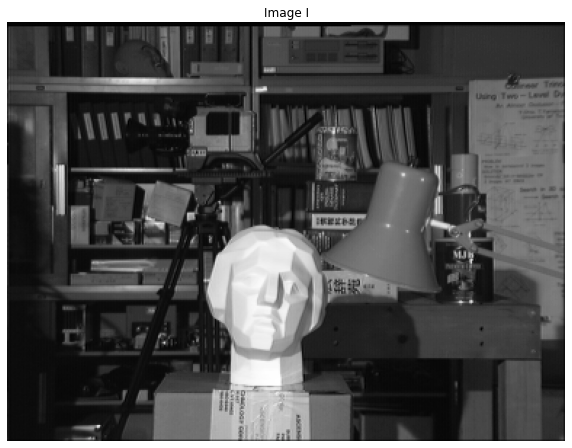

In [3]:
# Open image and convert to grayscale
path: pathlib.Path = pathlib.Path('./images/tsukuba/scene1.row3.col1.ppm')
img = numpy.array(PIL.Image.open(str(path)).convert('L'))

figure = matplotlib.pyplot.figure(figsize=(10, 10))

matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Image I')
_ = matplotlib.pyplot.imshow(img, cmap='gray')


## Calcul du gradient

### Sobel kernel

In [4]:
def dx(img: numpy.ndarray) -> numpy.ndarray:
    # Sobel for gradient x axe
    hx = numpy.array(
        [
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ]
    )
    return scipy.signal.convolve2d(img, hx, mode='same')

def dy(img: numpy.ndarray) -> numpy.ndarray:
    # Sobel for gradient y axe
    hy = numpy.array(
        [
            [-1, -2, -1],
            [0, 0, 0],
            [1, 2, 1]
        ]
    )
    return scipy.signal.convolve2d(img, hy, mode='same')

### Calcul du gradient par convolution 2D

$\begin{equation}
\nabla f = \begin{bmatrix}
    \frac{df}{dx} \\
    \frac{df}{dy}
\end{bmatrix}
\end{equation}$

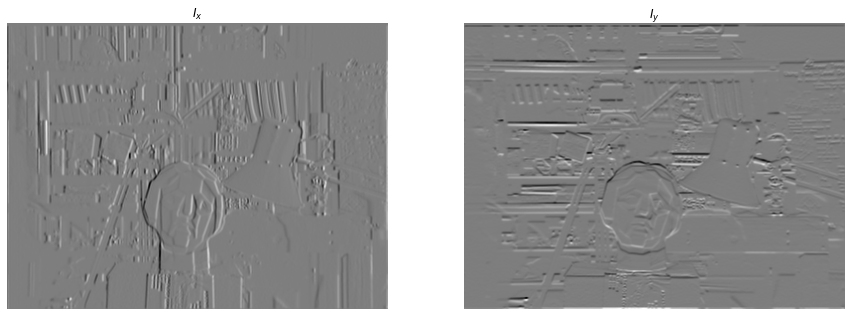

In [5]:
# Compute gradient

img_x = dx(img)
img_y = dy(img)

figure = matplotlib.pyplot.figure(figsize=(15, 15))

matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{x}$')
_ = matplotlib.pyplot.imshow(img_x, cmap='gray')

matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{y}$')
_ = matplotlib.pyplot.imshow(img_y, cmap='gray')

### Calcul de la Hessienne par convolution 2D

$\begin{equation}
Hess_f = \begin{bmatrix}
    \frac{df}{dxdx} & \frac{df}{dxdy} \\
    \frac{df}{dydx} & \frac{df}{dydy}
\end{bmatrix}
\end{equation}$

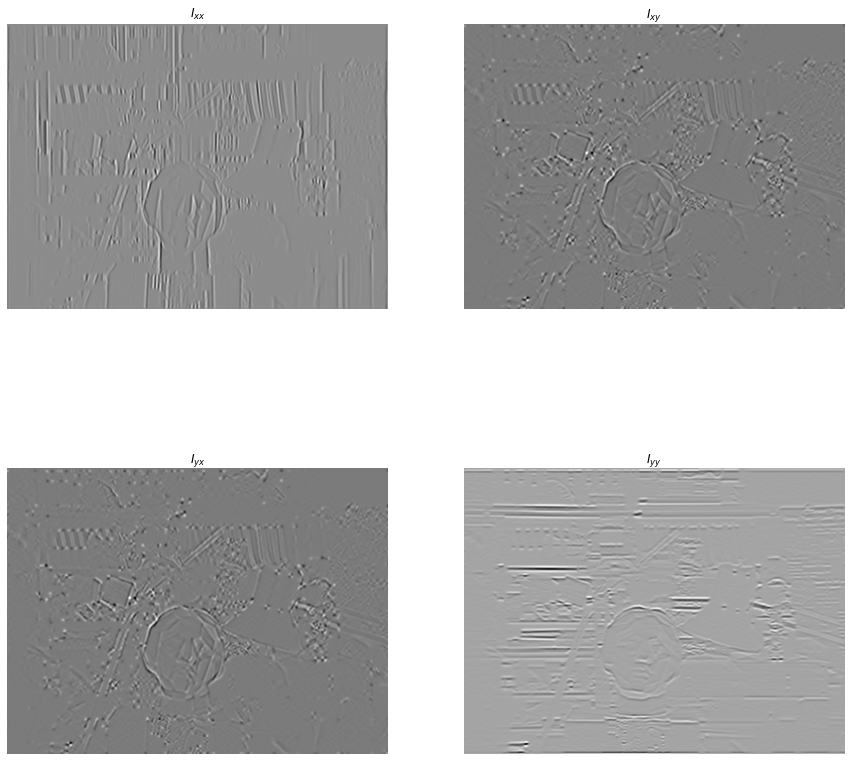

In [6]:
# Compute hessian

img_xx = dx(img_x)
img_xy = dy(img_x)
img_yx = dx(img_y)
img_yy = dy(img_y)

figure = matplotlib.pyplot.figure(figsize=(15, 15))

matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{xx}$')
_ = matplotlib.pyplot.imshow(img_xx, cmap='gray')


matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{xy}$')
_ = matplotlib.pyplot.imshow(img_xy, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{yx}$')
_ = matplotlib.pyplot.imshow(img_yx, cmap='gray')


matplotlib.pyplot.subplot(2, 2, 4)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('$I_{yy}$')
_ = matplotlib.pyplot.imshow(img_yy, cmap='gray')

## Calcul des reponses

### Outils

In [7]:
def remove_non_maxima(response: numpy.ndarray, size_neigh: int) -> numpy.ndarray:
    
    limit = size_neigh // 2
    response_p = response.copy()
    N, M = response_p.shape

    for i in range(limit, N-limit):
        for j in range(limit, M-limit):
            if response_p[i, j] != numpy.max(response_p[i-limit:i+limit+1, j-limit:j+limit+1]):
                response_p[i, j] = 0

    return response_p

# def select_best(response: numpy.ndarray, k: int) -> tuple[numpy.ndarray, numpy.ndarray]:
#     pass

def select_with_threshold(response: numpy.ndarray, threshold: int) -> tuple[numpy.ndarray, numpy.ndarray]:
    return numpy.where(threshold < response)

### Detecteur de Moravec

In [8]:
def moravec_detector(img: numpy.ndarray, i: int, j: int, size_search: int) -> float:

    N, M = img.shape
    limit = size_search // 2

    if size_search%2 != 1:
        raise AssertionError('search_size must be odd')
        
    if (i-limit < 0) or (N-1-limit < i+1) or (j-limit < 0) or (M-1-limit < j+1):
        raise AssertionError('Bord condition : (i, j) = ({}, {})'.format(i, j))

    def SSD(i, j, u, v):
        return numpy.sum((img[i-limit:i+limit+1, j-limit:j+limit+1] - img[u-limit:u+limit+1, v-limit:v+limit+1])**2)
    
    ssds: list = []

    for k in range(-limit, limit+1):
        for l in range(-limit, limit+1):
            # Problème de condition de bord
            if (k != 0) and (l != 0):
                ssds.append(SSD(i, j, i+k, j+l))
            

    return numpy.min(numpy.array(ssds))



In [9]:
# Compute response

def response_moravec(img: numpy.ndarray, size_search: int) -> numpy.ndarray:
    
    if size_search%2 != 1:
        raise AssertionError('search_size must be odd')

    # limit = size_search // 2

    N, M = img.shape
    response = numpy.zeros(img.shape)

    for i in range(size_search, N-size_search):
        for j in range(size_search, M-size_search):
            response[i, j] = moravec_detector(img, i, j, size_search)


    return response

In [10]:
# Parameters
SIZE_SEARCH = 3
SIZE_NEIGH = 3
THRESHOLD = 1_100

In [11]:
R = response_moravec(img, SIZE_SEARCH)
Rp = remove_non_maxima(R, SIZE_NEIGH)

In [12]:
x, y = select_with_threshold(Rp, THRESHOLD)

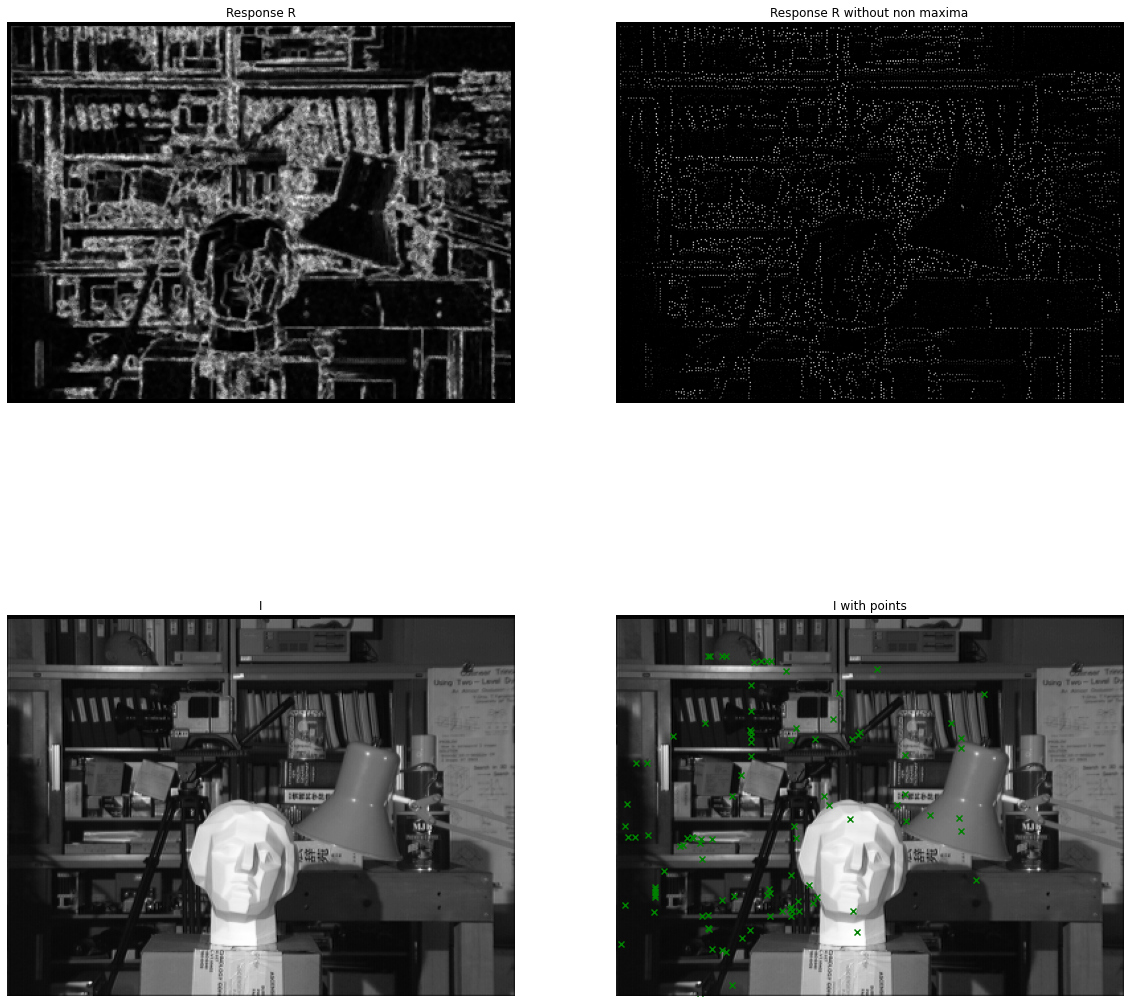

In [13]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))

matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Response R')
_ = matplotlib.pyplot.imshow(R, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Response R without non maxima')
_ = matplotlib.pyplot.imshow(Rp, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('I')
_ = matplotlib.pyplot.imshow(img, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 4)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('I with points')
matplotlib.pyplot.scatter(x, y, marker='x', color="green")
_ = matplotlib.pyplot.imshow(img, cmap='gray')

### Detecteur de Kitchen-Rosenfeld

In [14]:
def kitchen_rosenfeld_detector(
    img_x: numpy.ndarray, 
    img_y: numpy.ndarray, 
    img_xx: numpy.ndarray, 
    img_xy: numpy.ndarray, 
    img_yx: numpy.ndarray, 
    img_yy: numpy.ndarray
) -> numpy.ndarray:

    img_x2 = img_x**2
    img_y2 = img_y**2

    
    a = img_xx*img_y2 + img_yy*img_x2 - img_xy*img_x*img_y - img_yx*img_x*img_y
    b = img_x2 + img_y2
    return numpy.where(b != 0.0, a / b, 0.0)

    # pb avec une divison par zero
    # return (img_xx*img_y2 + img_yy*img_x2 - img_xy*img_x*img_y - img_yx*img_x*img_y) / (img_x2 + img_y2)
    # return (img_xx*img_y2 + img_yy*img_x2 - 2*img_xy*img_x*img_y) / (img_x2 + img_y2)


In [20]:
a = numpy.array([1, 1])
b = numpy.array([2, 0])
b, numpy.where(b != 0, a / b, 7)

/run/user/1000/ipykernel_6818/287392904.py:3: RuntimeWarning: divide by zero encountered in true_divide
  b, numpy.where(b != 0, a / b, 7)


(array([2, 0]), array([0.5, 7. ]))

In [16]:
def response_kitchen_rosenfeld(img: numpy.ndarray) -> numpy.ndarray:
    img_x = dx(img)
    img_y = dy(img)
    img_xx = dx(img_x)
    img_xy = dy(img_x)
    img_yx = dx(img_y)
    img_yy = dy(img_y)
    return kitchen_rosenfeld_detector(img_x, img_y, img_xx, img_xy, img_yx, img_yy)

In [17]:
# Parameters
SIZE_NEIGH = 3
THRESHOLD = 1_100

In [18]:
R = response_kitchen_rosenfeld(img)
Rp = remove_non_maxima(R, SIZE_NEIGH)

/run/user/1000/ipykernel_6818/3871526422.py:17: RuntimeWarning: invalid value encountered in true_divide
  res = num[zeros] / den[zeros]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Detecteur de Beaudet

In [ ]:
def beaudet_detector(
    img_xx: numpy.ndarray, 
    img_xy: numpy.ndarray, 
    img_yx: numpy.ndarray, 
    img_yy: numpy.ndarray
) -> numpy.ndarray:
    return numpy.abs(img_xx*img_yy-img_xy*img_yx)

In [ ]:
def response_beaudet(img: numpy.ndarray) -> numpy.ndarray:
    img_x = dx(img)
    img_y = dy(img)
    img_xx = dx(img_x)
    img_xy = dy(img_x)
    img_yx = dx(img_y)
    img_yy = dy(img_y)
    return beaudet_detector(img_xx, img_xy, img_yx, img_yy)

In [ ]:
# Parameters
SIZE_NEIGH = 3
THRESHOLD = 1_100

In [ ]:
R = response_beaudet(img)
Rp = remove_non_maxima(R, SIZE_NEIGH)

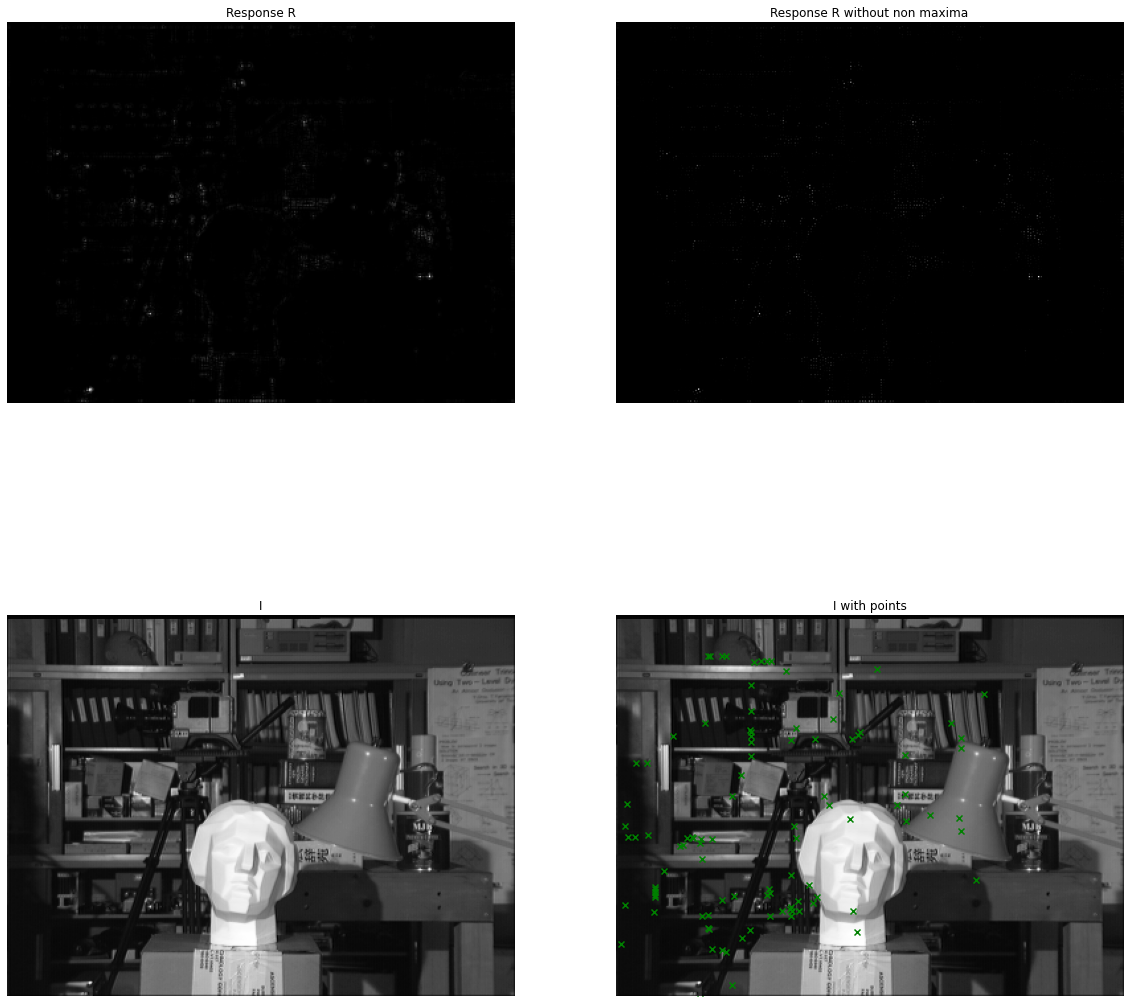

In [ ]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))

matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Response R')
_ = matplotlib.pyplot.imshow(R, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('Response R without non maxima')
_ = matplotlib.pyplot.imshow(Rp, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 3)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('I')
_ = matplotlib.pyplot.imshow(img, cmap='gray')

matplotlib.pyplot.subplot(2, 2, 4)
matplotlib.pyplot.axis('off')
matplotlib.pyplot.title('I with points')
matplotlib.pyplot.scatter(x, y, marker='x', color="green")
_ = matplotlib.pyplot.imshow(img, cmap='gray')

### Detecteur de Harris

In [ ]:
def harris_plessey_detector(Mij: numpy.ndarray, k: float = 0.04) -> float:
    # eigen_values = numpy.linalg.eigvals(Mij)
    a, b, c, d = Mij[0, 0], Mij[0, 1], Mij[1, 0], Mij[1, 1]
    lambda1: float = 0.5 * (a + c - numpy.sqrt((a-c)**2 + 4*b**2))
    lambda2: float = 0.5 * (a + c + numpy.sqrt((a-c)**2 + 4*b**2))
    detM: float = lambda1 * lambda2
    trM: float = lambda1 + lambda2
    return detM - k * trM

def noble_detector(Mij: numpy.ndarray, epsilon: float = 1e-15) -> float:
    # eigen_values = numpy.linalg.eigvals(Mij)
    a, b, c, d = Mij[0, 0], Mij[0, 1], Mij[1, 0], Mij[1, 1]
    lambda1: float = 0.5 * (a + c - numpy.sqrt((a-c)**2 + 4*b**2))
    lambda2: float = 0.5 * (a + c + numpy.sqrt((a-c)**2 + 4*b**2))
    detM: float = lambda1 * lambda2
    trM: float = lambda1 + lambda2
    return 2 * detM / (trM + epsilon)

def shi_tomasi_detector(Mij: numpy.ndarray) -> float:
    # eigen_values = numpy.linalg.eigvals(Mij)
    a, b, c, d = Mij[0, 0], Mij[0, 1], Mij[1, 0], Mij[1, 1]
    lambda1: float = 0.5 * (a + c - numpy.sqrt((a-c)**2 + 4*b**2))
    return lambda1

In [ ]:
def response_harris(img: numpy.ndarray, size_search: int, mu: float = 0.0, sigma: float = 0.1) -> numpy.ndarray:

    if size_search%2 != 1:
        raise AssertionError('search_size must be odd')

    limit = size_search // 2

    N, M = img.shape
    response = numpy.zeros(img.shape)
    
    img_x = dx(img)
    img_y = dy(img)
    img_x2 = img_x**2
    img_y2 = img_y**2

    w = numpy.random.normal(mu, sigma, size=(size_search, size_search))
    Mij = numpy.zeros(shape=(2, 2))

    for i in range(limit, N-limit):
        for j in range(limit, M-limit):
            Mij[0, 0] =  numpy.sum(w *(img_x2[i-limit:i+limit+1, j-limit:j+limit+1]))
            Mij[1, 1] =  numpy.sum(w *(img_y2[i-limit:i+limit+1, j-limit:j+limit+1]))
            Mij[0, 1] =  numpy.sum(w * img_x[i-limit:i+limit+1, j-limit:j+limit+1] * img_y[i-limit:i+limit+1, j-limit:j+limit+1])
            Mij[1, 0] = Mij[0, 1]
            response[i, j] = harris_plessey_detector(Mij, k=0.04)
            # response[i, j] = noble_detector(Mij, epsilon=1e-15)
            # response[i, j] = shi_tomasi_detector(Mij)

    return response

### Detecteur de Harris multi-échelle

In [ ]:
def harris_multi_scaling_detector():
    pass

### Detecteur de Harris-Laplace

In [ ]:
def harris_laplace_detector():
    pass

### Detecteur de SIFT

In [ ]:
def sift_detector():
    pass